In [14]:
import gym
import time
from pyvirtualdisplay import Display
import numpy as np
from gym.envs.classic_control import rendering
from time import sleep
import random
from collections import namedtuple

In [2]:
def repeat_upsample(rgb_array, k=1, l=1, err=[]):
    # repeat kinda crashes if k/l are zero
    if k <= 0 or l <= 0: 
        if not err: 
            print("Number of repeats must be larger than 0, k: {}, l: {}, returning default array!".format(k, l))
            err.append('logged')
        return rgb_array

    # repeat the pixels k times along the y axis and l times along the x axis
    # if the input image is of shape (m,n,3), the output image will be of shape (k*m, l*n, 3)

    return np.repeat(np.repeat(rgb_array, k, axis=0), l, axis=1)

In [3]:
env_name = "Breakout-ram-v0"

In [68]:
viewer = rendering.SimpleImageViewer()
env = gym.make(env_name)
env.reset()

action=0
done=False
total_rew=0
steps=0

rgb = env.render('rgb_array')
sleep(0.03)

while not done:
    upscaled=repeat_upsample(rgb,4, 4)
    viewer.imshow(upscaled)
    ac = env.action_space.sample()
    ob, rew, done, info = env.step(ac)
    total_rew += rew
    steps+=1
    rgb = env.render('rgb_array')
    sleep(0.03)

viewer.close()
env.close()

In [5]:
Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
from tensorflow.keras.layers import Dense, Conv2D, Input
import tensorflow as tf

class DQN(object):
    """Deep Q Network"""
    def __init__(self,n_actions,state_shape,learning_rate=0.00001,n_hidden_1=128,n_hidden_2=64):
        
        self.n_actions = n_actions
        self.input_shape = state_shape
        self.learning_rate = learning_rate

        self.inputs = Input(shape=self.input_shape,name='Input')
        self.x = Dense(n_hidden_1,activation='relu',name='Hidden1')(self.inputs)
        #self.x = Dense(n_hidden_2,activation='relu',name='Hidden2')(self.x)
        self.outputs = Dense(n_actions,name='Output')(self.x)

        self.model = tf.keras.Model(inputs=self.inputs, outputs=self.outputs, name='DQNetwork')

        self.loss = tf.keras.losses.Huber()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    
    def get_best_action(self,state):

        return tf.argmax(self.model(state),1)



In [57]:
class ActionScheduler(object):

    def __init__(self,
                 DQNetwork,
                 max_steps,
                 n_actions,
                 eps_start=1,
                 eps_end_exploration=0.1,
                 eps_end=0.01,
                 exploration_steps=1000000,
                 full_exploration_steps=50000):
        
        self.DQNetwork = DQNetwork
        self.max_steps = max_steps
        self.n_actions = n_actions

        self.eps_start = eps_start
        self.eps_end_exploration = eps_end_exploration
        self.eps_end = eps_end
        self.exploration_steps = exploration_steps
        self.full_exploration_steps = full_exploration_steps
        self.no_exploration_steps = self.max_steps-self.full_exploration_steps-self.exploration_steps

        self.slope_exploration = -(self.eps_start-self.eps_end_exploration)/self.exploration_steps
        self.intercept = self.eps_start - self.slope_exploration*self.full_exploration_steps
        self.final_slope = -(self.eps_end_exploration-self.eps_end)/(self.no_exploration_steps)
        self.intercept_2 = self.eps_end - self.final_slope*self.max_steps

    def compute_current_eps(self,step):
        if step<=self.full_exploration_steps:
            eps = self.eps_start
        elif step>self.full_exploration_steps and step<=(self.full_exploration_steps + self.exploration_steps):
            eps = step*self.slope_exploration + self.intercept
        else:
            eps = step*self.final_slope + self.intercept_2
        return eps
    
    def get_action(self,state,step):

        eps = self.compute_current_eps(step)

        if np.random.rand(1) < eps:
            return np.random.randint(0, self.n_actions)
        return self.DQN.get_best_action(state)


In [62]:
sample_state = np.array([1,2,3,4],dtype='uint8')
entry_data = np.expand_dims(sample_state,axis=0)

print(entry_data.shape)

DQNetwork = DQN(3,sample_state.shape)

print(DQNetwork.model.predict(entry_data))
print(DQNetwork.get_best_action(entry_data).numpy())

(1, 4)
[[-0.15805109  0.09489013  0.2951107 ]]
[2]


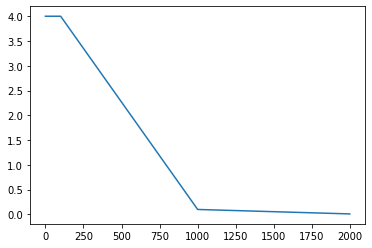

In [63]:
scheduler = ActionScheduler(0,2000,4,exploration_steps=900,full_exploration_steps=100)
eps_values = []
for i in range(2000):
    eps_values.append(scheduler.compute_current_eps(i))

import matplotlib.pyplot as plt
plt.plot(range(2000),eps_values)
plt.show()